In [4]:
import numpy as np
import os
import sys
import shutil
nexus_path = os.path.abspath("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/")
sys.path.append(nexus_path)
bin_path = os.path.abspath("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/bin/")
sys.path.append(bin_path)
from density import readDensityHeader, writeDensityData

In [5]:
gridsize = 512
sidelen = 106.5

In [11]:
def giveheader(demoden,DTFEden,outputname,gridsize,sidelen):
    #First we read a file with a good header to edit
#     l = readDensityHeader("demo_density.a_den")
    l = readDensityHeader(demoden)
    #And we read the output from DTFE
    den = np.array(np.fromfile(DTFEden,dtype=np.float32))

    #Then we define the header parts we want to change
#     gridsize = 512
#     sidelen = 106.5

    #And we put them in the header
    l.gridSize = np.array([gridsize,gridsize,gridsize])
    l.totalGrid = gridsize**3
    l.box = np.array([0.,sidelen,0.,sidelen,0.,sidelen])
    #Finally we write the new header with the density data to a new NEXUS-ready file
    writeDensityData(outputname,l,den)

def runNEXUS(densityFile,minscale,maxscale,outputDir="/Users/users/nastase/PROJECT/DATA/nexus_outputs/MMF_outputs/", binDir=bin_path,startat=0):
    
    
    node_maxResponse = os.path.join(outputDir, 'node_maxResponse.MMF')
    node_threshold = os.path.join(outputDir, 'node.threshold')
    node_clean = os.path.join(outputDir, 'node_clean.MMF')
    fila_maxResponse = os.path.join(outputDir, 'fila_maxResponse.MMF')
    fila_threshold = os.path.join(outputDir, 'fila.threshold')
    fila_clean = os.path.join(outputDir, 'fila_clean.MMF')
    wall_maxResponse = os.path.join(outputDir, 'wall_maxResponse.MMF')
    wall_threshold = os.path.join(outputDir, 'wall.threshold')
    wall_clean = os.path.join(outputDir, 'wall_clean.MMF')
    all_clean = os.path.join(outputDir, 'all_clean.MMF')
    
    # Once you have the density, you can run the NEXUS algorithm
    # the following computes the node/cluster maximum signature using the NEXUS_den method. We don't use NEXUS++ since it does not fare that well for cluster detection. The option '--den' selects the NEXUS_den method.
    # The program takes as input the density file and a range of scales that give the set of scales used in the multiscale analysis. In this case, the set of scales '0-6' tell the program to compute the node signature for smoothing scales R=R_0 sqqrt(2)^N with N=0 to 6. These 7 smoothing scales are used to compute the overall scale independent signature. Using the default arguments in the program, the filter scales range from 0.5 to 4 Mpc/h.
    # The option '--node' tells the code to compute the signature for nodes while the next argument gives the root name for the output file. In this case the output file is 'node_maxResponse.MMF'.
#     nexus_response_1 = '{0}/MMF_response {1} {2}-{3} --den --node node'.format( binDir, densityFile,minscale,maxscale )
    nexus_response_1 = '{0}/MMF_response {1} {2}-{3} --den --node {4}'.format(binDir, densityFile, minscale, maxscale, node_maxResponse)
    
    # Once we have the node maximum signature, we run 'MMF_threshold' to get the optimal threshold for node detection
    # 'node_maxResponse.MMF' is the input maximum signature file while 'node.threshold' is an output text file containing the data used to get the optimal threshold. The value of the optimal threshold using the method described in the NEXUS paper is given in the 1st line of file  'node.threshold'.
    # Option '--cleanFile node_clean.MMF' tells the program to output a file with all the regions above the threshold as values of 1 - this corresponds to valid clusters while the remaining voxels have a value of 0.
    # Option '--node' specify that the threshold should be computed for nodes.
    # Option '--virDen 350' gives the value of the virial density with respect to background density at the snapshot redshift. 
    # Option '--minSize 5.e13' gives the smallest mass (in Msolar/h units) that an object must have to be considered a valid cluster.
    # Option '--densityFile {1}' gives the name of the density file used to obtain the node signature. This is used to compute the mass inside cluster regions.
#     nexus_threshold_1 = '{0}/MMF_threshold node_maxResponse.MMF node.threshold --node --minSize 5.e13 --virDen 350 --cleanFile node_clean.MMF --densityFile {1}'.format( binDir, densityFile )
    nexus_threshold_1 = '{0}/MMF_threshold {1} {2} --node --minSize 5.e13 --virDen 350 --cleanFile {3} --densityFile {4}'.format(binDir, node_maxResponse, node_threshold, node_clean, densityFile)



    # This step computes the filament and wall maximum response using the NEXUS+ method (program option '--logFilter').
    # The option '--fila fila' specifies to compute the filament maximum signature and to output it to the file 'fila_maxResponse.MMF'.
    # The option '--wall wall' specifies to compute the wall maximum signature and to output it to the file 'wall_maxResponse.MMF'.
    # For more details see the comments for command: nexus_response_1
#     nexus_response_2 = '{0}/MMF_response {1} {2}-{3} --logFilter --fila fila --wall wall'.format( binDir, densityFile,minscale,maxscale )
    nexus_response_2 = '{0}/MMF_response {1} {2}-{3} --logFilter --fila {4} --wall {5}'.format(binDir, densityFile, minscale, maxscale, fila_maxResponse, wall_maxResponse)



    # This steps computes the optimal detection threshold for filaments
    # Takes as input the filament maximum signature 'fila_maxResponse.MMF' and outputs the data used for threshold computation in file 'fila.threshold'.
    # Option '--fila' specifies that the input file is a filament signature one.
    # Option '--minSize 10' specify the minimum volume in (Mpc/h)^3 that a distinct filament must have to be considered a valid feature. Distinct objects with smaller volume are discarded.
    # Option '--cleanFile fila_clean.MMF' specifies to output the clean filament file. The file contains a value of 1 for filament voxels and 0 otherwise.
    # Option '--densityFile density.a_den' gives the density file and is used to compute the mass in filaments and how it changes with filament signature.
    # Option '--nodeFile node_clean.MMF' gives the node clean file compute in a previous step that is used to mask the node regions. This means that a cluster region will not be identified also as a filament.
#     nexus_threshold_2 = '{0}/MMF_threshold fila_maxResponse.MMF fila.threshold --fila --minSize 10 --cleanFile fila_clean.MMF --densityFile {1} --nodeFile node_clean.MMF'.format( binDir, densityFile )
    nexus_threshold_2 = '{0}/MMF_threshold {1} {2} --fila --minSize 10 --cleanFile {3} --densityFile {4} --nodeFile {5}'.format(binDir, fila_maxResponse, fila_threshold, fila_clean, densityFile, node_clean)


    # This steps computes the optimal detection threshold for walls.
    # Takes as input the wall maximum signature 'wall_maxResponse.MMF' and outputs the data used for threshold computation in file 'wall.threshold'.
    # The options are exactly the same as for the filament detection thershold, so see description above.
    # Option '--filaFile fila_clean.MMF' gives the fila clean file compute in a previous step that is used to mask the filamentary regions. This means that a filament region will not be identified also as a wall region.
#     nexus_threshold_3 = '{0}/MMF_threshold wall_maxResponse.MMF wall.threshold --wall --minSize 10 --cleanFile wall_clean.MMF --densityFile {1} --nodeFile node_clean.MMF --filaFile fila_clean.MMF '.format( binDir, densityFile )
    nexus_threshold_3 = '{0}/MMF_threshold {1} {2} --wall --minSize 10 --cleanFile {3} --densityFile {4} --nodeFile {5} --filaFile {6}'.format(binDir, wall_maxResponse, wall_threshold, wall_clean, densityFile, node_clean, fila_clean)

    # This last steps combines the 3 clean files for nodes, filaments and walls in a single environment file.
    # Takes as input options: node clean file, filament clean file and wall clean file.
    # The last option gives the output file for the combined environment response. The output is saved in 2-bytes integers with 0=voids, 2=walls, 3=filaments and 4=clusters. 
#     nexus_combine = '{0}/MMF_combine.py node_clean.MMF fila_clean.MMF wall_clean.MMF all_clean.MMF'.format( binDir )
    nexus_combine = '{0}/MMF_combine.py {1} {2} {3} {4}'.format(binDir, node_clean, fila_clean, wall_clean, all_clean)


    # Writes all the commands in a list. Later on a loop over the list will execute all commands in the specified order.
    commands = [
            nexus_response_1,
            nexus_threshold_1,
            nexus_response_2,
            nexus_threshold_2,
            nexus_threshold_3,
            nexus_combine
            ]



    # run the code for each part
    for i in range(startat,len(commands)):    #loop over all parts
        print("\tRunning part %i of %i parts ..." % (i+1,len(commands)))

        toRun = commands[i]
        #print("\nRUNNING:\n\t%s\n" % toRun)

        status = os.system( toRun )
        if status != 0: # an error took place
            sys.exit(1)
    #print("Finished running NEXUS")

def readNEXUS(densityFile,gridsize,vel=False,velFile=None):
    #This function will read the files generated by runNEXUS and make them into numpy arrays
    #It can also read DTFE velocity files as an extra option
    #The order is as follows, it returns:
    #Densityfield, NEXUS_nodes, NEXUS_filaments, NEXUS_walls, Velocity (optional)
    #The NEXUS arrays can then be used for contours or converted into boolean arrays
    #Where all cells > 0 are part of the corresponding structure
    #Voids are located where the other three components are all 0 
    shape = (gridsize,gridsize,gridsize)
    denfield = np.fromfile(densityFile,dtype=np.float32)
    denfield = np.reshape(denfield[262:-2],shape)
    MMFn = np.fromfile("node_clean.MMF",dtype=np.int16)
    MMFn = np.reshape(MMFn[527:-1],shape)
    MMFf = np.fromfile("fila_clean.MMF",dtype=np.int16)
    MMFf = np.reshape(MMFf[527:-1],shape)
    MMFw = np.fromfile("wall_clean.MMF",dtype=np.int16)
    MMFw = np.reshape(MMFw[527:-1],shape)
    #Correct for the z-axis missallignment of the density field wrt NEXUS
    def maxmean(densf,MMFfila,axisn,ran):
        k = np.zeros(ran)
        for i in range(ran):
            k[i] = np.mean(np.roll(densf,i,axis=axisn)[MMFfila>0])
        return np.argmax(k)
    
    shift = maxmean(denfield,MMFf,2,gridsize)
    denfield = np.roll(denfield,shift,axis=2)
    if vel==True:
        velo = np.fromfile(velFile,dtype=np.float32)
        k = np.reshape(velo,(gridsize,gridsize,gridsize,3))
        k = np.roll(k,shift,axis=2)
        return denfield, MMFn, MMFf, MMFw, k
    else:
        return denfield, MMFn, MMFf, MMFw
    


In [12]:
#These function are also available from the file pyNEXUS.py
# from pyNEXUS import giveheader, runNEXUS, readNEXUS
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#I try saving a copy of the original file, in case of bad writing practices of the program
tempfile = "/Users/users/nastase/PROJECT/DATA/nexus_outputs/output_135.a_den"

In [19]:
#Lets first show a quick example of how we use the functions.
#Lets assume we have used DTFE to get a file named "periodic7.a_den"
#and we would like to run NEXUS and make a contour plot that highlights
#the found filaments

#First we have to add a header to the DTFE file, we do this with giveheader
#This first entry should be a file with a working header like th demo file
#found in the demo folder of NEXUS
#The second entry is our DTFE file
#The third entry is the output file name
#It is usefull to have this string as a seperate variable as we use it multiple times
#The fourth entry is the gridsize (Which you enter for DTFE aswell)
#The fifth entry is the sidelenght of the box in Mpc


giveheader("/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/demo/demo_density.a_den","/Users/users/nastase/PROJECT/DATA/gadget_dtfe/output_135.a_den",tempfile,512,106.5)

Reading the header of the density file '/Users/users/nastase/Applications/NEXUS_python/NEXUS_1.0/demo/demo_density.a_den' ...  Done
Writing the density data to the file '/Users/users/nastase/PROJECT/DATA/nexus_outputs/output_135.a_den' ...  Done.


In [20]:
tempfile

'/Users/users/nastase/PROJECT/DATA/nexus_outputs/output_135.a_den'

In [21]:
#Now we have a usable density file and it's time to run NEXUS
#For this we use the function runNEXUS.
#runNEXUS takes as a first entry the name of the density file (in this case tempfile)
#the second and third entries are the minimum and maximum scale of filtering
#2 and 6 are are good standard values for this
#Then there is an option to skip certain steps: startat, this is most useful when
#the program runs into problems finding nodes, startat=2 fixes this
#And finally you have to set the binDir for NEXUS when using it from a folder that
#is not NEXUS_test o my dataserver

runNEXUS(tempfile,0,6) # Change as you wish

	Running part 1 of 6 parts ...
	Running part 2 of 6 parts ...


SystemExit: 1

/Software/users/modules/7/software/anaconda3/4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
#Now that we have all we need we can do some simple plotting
#Index for plotting
i = 203

In [12]:
#Now all that is left to do is read out the NEXUS files this is done with readNEXUS
#readNEXUS takes the density file (tempfile in this case) as first entry and
#the gridsize as a second entry and this all it needs
#in the case of also using a velocity field you can add it by adding vel=True
#and puting velFile="your velocity file"
#This function returns in order: the density field, the nodes, the filaments, the walls
denfield, MMFn, MMFf, MMFw = readNEXUS(tempfile,gridsize,vel=False,velFile=None)

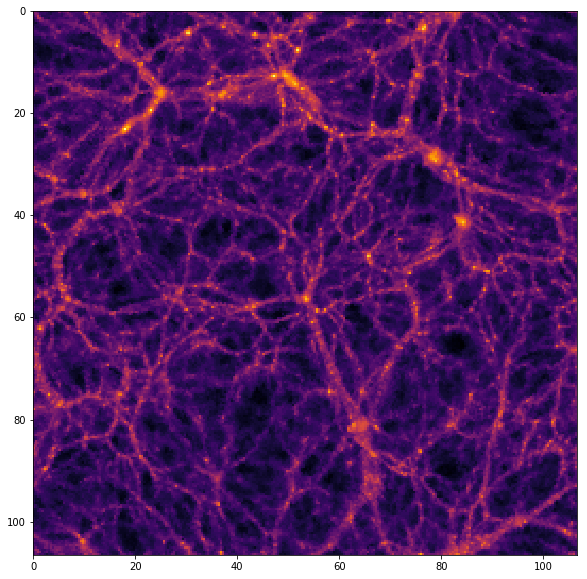

In [13]:
fig = plt.figure(figsize=(10,10))
im = plt.imshow(np.log(denfield[:,:,i]),cmap="inferno",extent=[0,sidelen,sidelen,0])
plt.show()

In [53]:
np.shape(denfield)

(256, 256, 256)

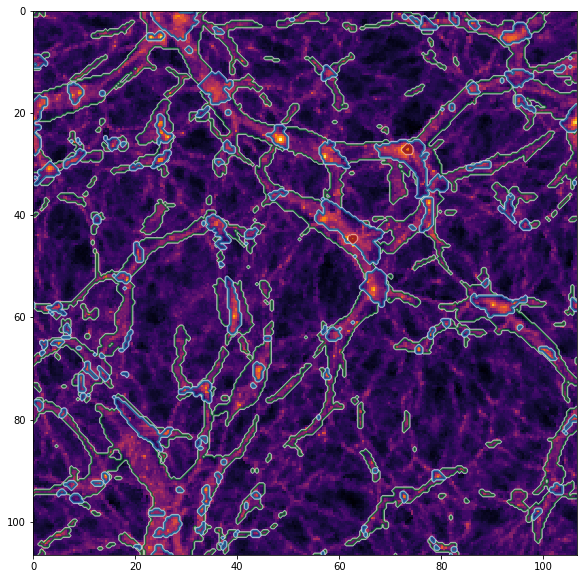

In [14]:
#Plotting
i2 = 78
x, y = np.meshgrid(np.linspace(0,sidelen,gridsize),np.linspace(0,sidelen,gridsize))
fig = plt.figure(figsize=(10,10))
im = plt.imshow(np.log(denfield[:,i2,:]),cmap="inferno",extent=[0,sidelen,sidelen,0])
plt.contour(x,y,MMFw[:,i2,:],level=1,cmap="Greens",linewidths=1,alpha=0.5)
plt.contour(x,y,MMFf[:,i2,:],level=1,cmap="Blues",linewidths=1.5,alpha=0.5)
plt.contour(x,y,MMFn[:,i2,:],level=1,cmap="Reds",linewidths=3,alpha=0.5)
plt.show()

In [41]:
#Having each as a seperate function is usefull as we can now work with more then 1
#Snapshot at a time, an example of this can be seen in this cell
#Calculate volume and mass fractions for the different elements

def cwfracs(MMFn,MMFf,MMFw,denfield):
    #Simple function that calculates the mass and volume fractions using NEXUS
    nfrac = len(MMFn.flatten()[MMFn.flatten()>0])/len(MMFn.flatten())
    nmfrac = np.mean((denfield[MMFn>0]))*nfrac

    ffrac = len(MMFf.flatten()[MMFf.flatten()>0])/len(MMFf.flatten())
    fmfrac = np.mean((denfield[MMFf>0]))*ffrac

    wfrac = len(MMFw.flatten()[MMFw.flatten()>0])/len(MMFw.flatten())
    wmfrac = np.mean((denfield[MMFw>0]))*wfrac
    
    vfracs = np.array([ffrac, 1-(nfrac+ffrac+wfrac),wfrac,nfrac])*100
    mfracs = np.array([fmfrac,1-(nmfrac+fmfrac+wmfrac),wmfrac,nmfrac])*100
    return vfracs,mfracs

#After initiating a small list of commands we can loop over all the snaps
avfrac = np.zeros((8,4))
amfrac = np.zeros((8,4))
str1 = "periodic"
str2 = ".a_den"
tempden = "out.den"
for i in range(8):
    DTFEfile = str1 + str(i) + str2
    giveheader("demo_density.a_den",DTFEfile,tempden,gridsize,sidelen)
    #For this set of snapshots NEXUS has difficult of finding nodes at a few redshifts
    #This makes it so that NEXUS does not search for them in those snaps
    if i < 4 and i != 0:
        runNEXUS(tempden,2,6,startat=2)
    else:
        runNEXUS(tempden,2,6)
    denfield, MMFn, MMFf, MMFw = readNEXUS(tempden,gridsize,vel=False,velFile=None)
    vout, mout = cwfracs(MMFn,MMFf,MMFw,denfield)
    avfrac[i,:] = vout
    amfrac[i,:] = mout



~~~ ERROR ~~~  Cannot find the density binary file. There are no 'demo_density.a_den' or 'demo_density.a_den.0' files.         


SystemExit: 1

/Software/users/modules/7/software/anaconda3/4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


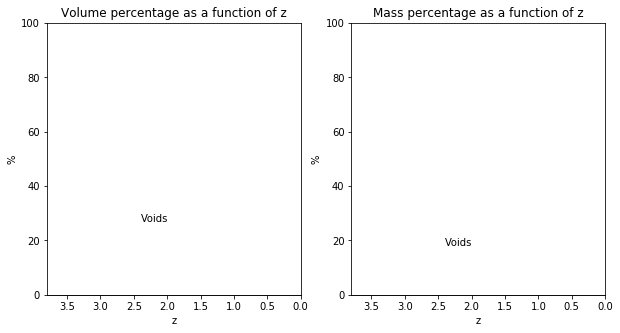

In [42]:
#The results we can now plot
import matplotlib.pyplot as plt

vparr = avfrac
mparr = amfrac
zarr = np.array([3.8, 2.98, 2.05, 1.00, 0.51, 0.25, 0.1, 0])

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.fill_between(zarr,0,vparr[:,1],color="orange")
ax1.fill_between(zarr,vparr[:,1],vparr[:,1]+vparr[:,0],color="blue")
ax1.fill_between(zarr,vparr[:,1]+vparr[:,0],vparr[:,0]+vparr[:,1]+vparr[:,2],color="green")
ax1.fill_between(zarr,vparr[:,1]+vparr[:,0]+vparr[:,2],vparr[:,0]+vparr[:,1]+vparr[:,2]+vparr[:,3],color="red")
ax1.text(2.4,66,"Filaments",color="white")
ax1.text(2.4,27,"Voids",color="black")
ax1.text(2.4,84,"Walls",color="white")
ax1.set_xlim(3.8,0)
ax1.set_ylim(0,100)
ax1.set_xlabel("z")
ax1.set_ylabel("%")
ax1.set_title("Volume percentage as a function of z")
ax2 = fig.add_subplot(122)
ax2.fill_between(zarr,0,mparr[:,1],color="orange")
ax2.fill_between(zarr,mparr[:,1],mparr[:,0]+mparr[:,1],color="blue")
ax2.fill_between(zarr,mparr[:,0]+mparr[:,1],mparr[:,0]+mparr[:,1]+mparr[:,2],color="green")
ax2.fill_between(zarr,mparr[:,0]+mparr[:,1]+mparr[:,2],mparr[:,0]+mparr[:,1]+mparr[:,2]+mparr[:,3],color="red")
ax2.text(2.4,54,"Filaments",color="white")
ax2.text(2.4,18,"Voids",color="black")
ax2.text(2.4,84,"Walls",color="white")
ax2.set_xlim(3.8,0)
ax2.set_ylim(0,100)
ax2.set_xlabel("z")
ax2.set_ylabel("%")
ax2.set_title("Mass percentage as a function of z")
plt.show()

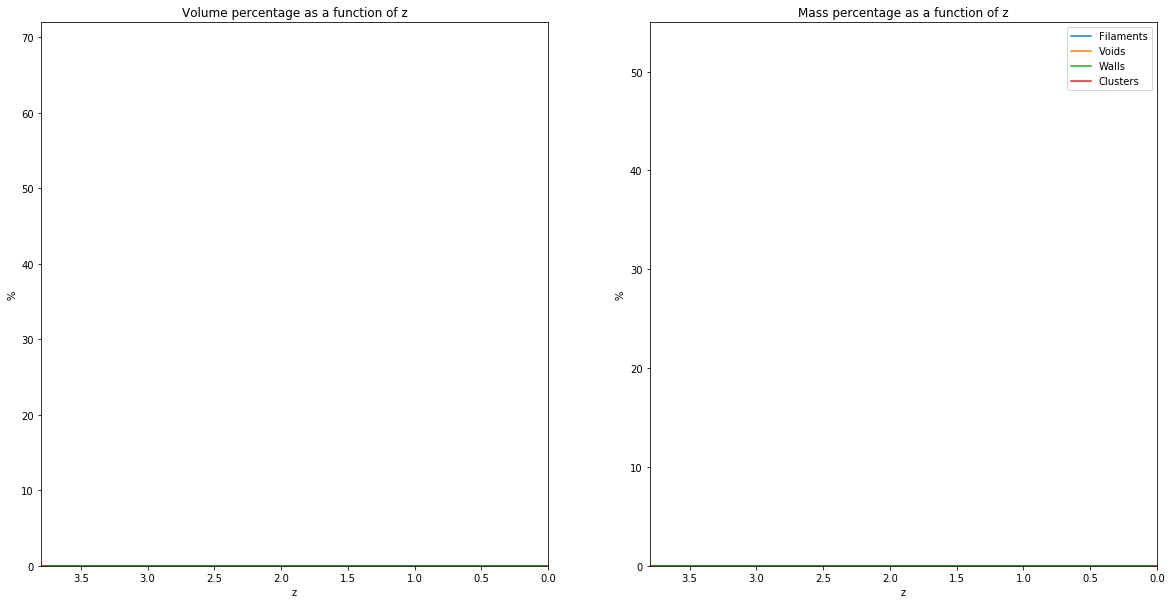

In [85]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(zarr,vparr[:,0],label="Filaments")
ax1.plot(zarr,vparr[:,1],label="Voids")
ax1.plot(zarr,vparr[:,2],label="Walls")
ax1.plot(zarr,vparr[:,3],label="Clusters")
ax1.set_xlim(3.8,0)
ax1.set_ylim(0,72)
ax1.set_xlabel("z")
ax1.set_ylabel("%")
ax1.set_title("Volume percentage as a function of z")
ax2 = fig.add_subplot(122)
ax2.plot(zarr,mparr[:,0],label="Filaments")
ax2.plot(zarr,mparr[:,1],label="Voids") 
ax2.plot(zarr,mparr[:,2],label="Walls")
ax2.plot(zarr,mparr[:,3],label="Clusters")
ax2.set_xlim(3.8,0)
ax2.set_ylim(0,55)
ax2.legend()
ax2.set_xlabel("z")
ax2.set_ylabel("%")
ax2.set_title("Mass percentage as a function of z")
plt.show()

In [43]:
import scipy.fftpack as scft
def divergencefield(velx,vely,velz,gridsize,sidelen,filt=False,filtscale=1):
    #This function calculates the divergence at each point of the field
    #in Fourier space
    
    #First of all the option is given to filter the field before calculating
    #the divergence
    if filt==True:
        velx = Gausfilt(velx,gridsize,sidelen,filtscale)
        vely = Gausfilt(vely,gridsize,sidelen,filtscale)
        velz = Gausfilt(velz,gridsize,sidelen,filtscale)
    #Here we calculate the Fourier grid
    freqs = np.fft.fftfreq(gridsize,d=(sidelen/gridsize))
    ygrid, xgrid, zgrid = np.meshgrid(freqs,freqs,freqs)  
    #Then we calculatue the FFT of the velocity field and create a vector
    vels = np.array([scft.fftn(velx,axes=[0,1,2]),scft.fftn(vely,axes=[0,1,2]),scft.fftn(velz,axes=[0,1,2])],dtype=complex)
    #Then we calculate the real space divergence in Fourier space and perform the
    #Inverse FFT
    xcal = 1j*vels[0,:,:,:]*xgrid*np.pi
    ycal = 1j*vels[1,:,:,:]*ygrid*np.pi
    zcal = 1j*vels[2,:,:,:]*zgrid*np.pi
    Fftarr = xcal+ycal+zcal
    enddiv = np.real(scft.ifftn(Fftarr))
    return enddiv

#After initiating a small list of commands we can loop over all the snaps
avfrac = np.zeros((8,4))
amfrac = np.zeros((8,4))
avdiv  = np.zeros((8,5))
str1 = "periodic"
str2 = ".a_den"
str3 = ".vel"
tempden = "out.den"
gridsize = 128
sidelen = 300
for i in range(8):
    DTFEfile = str1 + str(i) + str2
    velofile = str1 + str(i) + str3
    giveheader("demo_density.a_den",DTFEfile,tempden,gridsize,sidelen)
    #For this set of snapshots NEXUS has difficult of finding nodes at a few redshifts
    #This makes it so that NEXUS does not search for them in those snaps
    if i < 4 and i != 0:
        runNEXUS(tempden,2,6,startat=2)
        g = 4000
    else:
        runNEXUS(tempden,2,6)
        g = 0
    denfield, MMFn, MMFf, MMFw, k = readNEXUS(tempden,gridsize,vel=True,velFile=velofile)
    vout, mout = cwfracs(MMFn,MMFf,MMFw,denfield)
    avfrac[i,:] = vout
    amfrac[i,:] = mout
    divfield = divergencefield(k[:,:,:,0],k[:,:,:,1],k[:,:,:,2],gridsize,300)
    nmeandiv = np.sum(divfield[MMFn>0])+ g
    fmeandiv = np.sum(divfield[MMFf>0])
    wmeandiv = np.sum(divfield[MMFw>0])
    vmeandiv = np.sum(divfield[(MMFn==0)*(MMFf==0)*(MMFw==0)])
    totdiv =  np.sum(divfield)
    avdiv[i,:] = np.array([nmeandiv,fmeandiv,wmeandiv,vmeandiv,totdiv])



~~~ ERROR ~~~  Cannot find the density binary file. There are no 'demo_density.a_den' or 'demo_density.a_den.0' files.         


SystemExit: 1

/Software/users/modules/7/software/anaconda3/4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


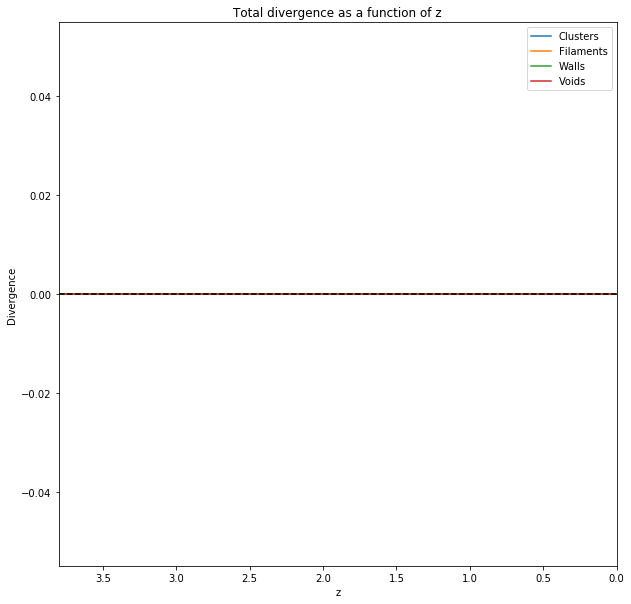

In [87]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.plot(zarr[4:],avdiv[4:,0],label="Clusters")
ax1.plot(zarr,avdiv[:,1],label="Filaments")
ax1.plot(zarr,avdiv[:,2],label="Walls")
ax1.plot(zarr,avdiv[:,3],label="Voids")
ax1.axhline(0,linestyle="dashed",color="black")
ax1.set_xlim(3.8,0)
#ax1.set_ylim(0,72)
ax1.set_xlabel("z")
ax1.set_ylabel("Divergence")
plt.legend()
ax1.set_title("Total divergence as a function of z")
plt.show()

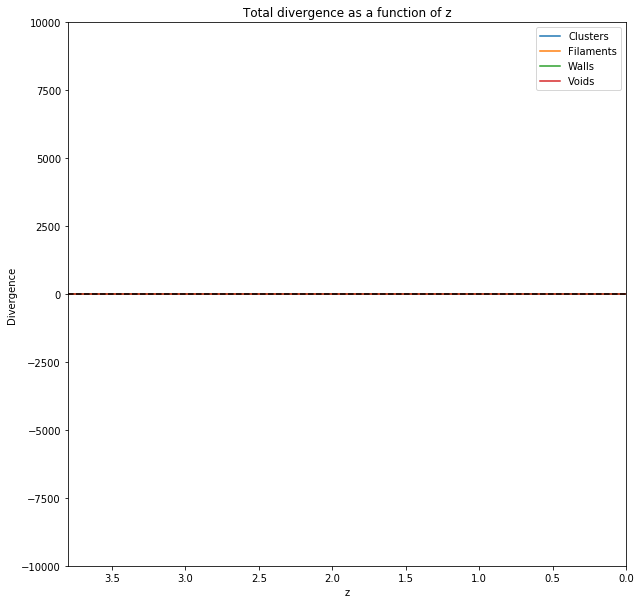

In [88]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.plot(zarr[4:],avdiv[4:,0],label="Clusters")
ax1.plot(zarr,avdiv[:,1],label="Filaments")
ax1.plot(zarr,avdiv[:,2],label="Walls")
ax1.plot(zarr,avdiv[:,3],label="Voids")
ax1.axhline(0,linestyle="dashed",color="black")
ax1.set_xlim(3.8,0)
ax1.set_ylim(-10000,10000)
ax1.set_xlabel("z")
ax1.set_ylabel("Divergence")
plt.legend()
ax1.set_title("Total divergence as a function of z")
plt.show()

In [89]:
avfrac = np.zeros((6,4))
amfrac = np.zeros((6,4))
avdiv  = np.zeros((6,5))
str1 = "periodic"
str2 = ".a_den"
str3 = ".vel"
tempden = "out.a_den"
gridsize = 128
sidelen = 300
for i in range(6):
    DTFEfile = str1 + str(7) + str2
    velofile = str1 + str(7) + str3
    giveheader("demo_density.a_den",DTFEfile,tempden,gridsize,sidelen)
    #For this set of snapshots NEXUS has difficult of finding nodes at a few redshifts
    #This makes it so that NEXUS does not search for them in those snaps
    #if i < 4 and i != 0:
    #    runNEXUS(tempden,0,6+i,startat=2)
    #    g = 4000
    #else:
    runNEXUS(tempden,0+i,14)
    #    g = 0
    denfield, MMFn, MMFf, MMFw, k = readNEXUS(tempden,gridsize,vel=True,velFile=velofile)
    vout, mout = cwfracs(MMFn,MMFf,MMFw,denfield)
    avfrac[i,:] = vout
    amfrac[i,:] = mout
    divfield = divergencefield(k[:,:,:,0],k[:,:,:,1],k[:,:,:,2],gridsize,300)
    nmeandiv = np.sum(divfield[MMFn>0])
    fmeandiv = np.sum(divfield[MMFf>0])
    wmeandiv = np.sum(divfield[MMFw>0])
    vmeandiv = np.sum(divfield[(MMFn==0)*(MMFf==0)*(MMFw==0)])
    totdiv =  np.sum(divfield)
    avdiv[i,:] = np.array([nmeandiv,fmeandiv,wmeandiv,vmeandiv,totdiv])



~~~ ERROR ~~~  Cannot find the density binary file. There are no 'demo_density.a_den' or 'demo_density.a_den.0' files.         


SystemExit: 1

/Software/users/modules/7/software/anaconda3/4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


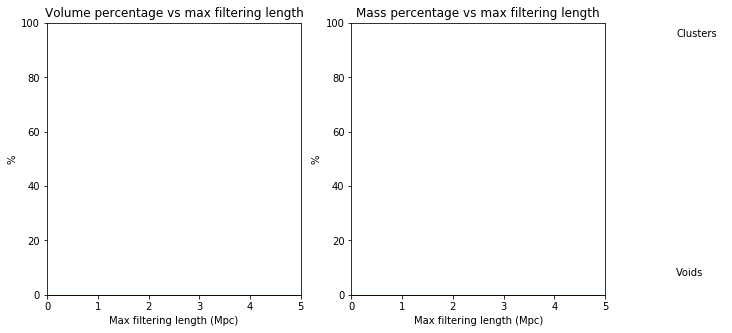

In [90]:
#The results we can now plot
import matplotlib.pyplot as plt

vparr = avfrac
mparr = amfrac
zarr = np.arange(6)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.fill_between(zarr,0,vparr[:,1],color="orange")
ax1.fill_between(zarr,vparr[:,1],vparr[:,1]+vparr[:,0],color="blue")
ax1.fill_between(zarr,vparr[:,1]+vparr[:,0],vparr[:,0]+vparr[:,1]+vparr[:,2],color="green")
ax1.fill_between(zarr,vparr[:,1]+vparr[:,0]+vparr[:,2],vparr[:,0]+vparr[:,1]+vparr[:,2]+vparr[:,3],color="red")
ax1.text(6.4,72,"Filaments",color="white")
ax1.text(6.4,27,"Voids",color="black")
ax1.text(6.4,84,"Walls",color="white")
ax1.set_xlim(0,5)
ax1.set_ylim(0,100)
ax1.set_xlabel("Max filtering length (Mpc)")
ax1.set_ylabel("%")
ax1.set_title("Volume percentage vs max filtering length")
ax2 = fig.add_subplot(122)
ax2.fill_between(zarr,0,mparr[:,1],color="orange")
ax2.fill_between(zarr,mparr[:,1],mparr[:,0]+mparr[:,1],color="blue")
ax2.fill_between(zarr,mparr[:,0]+mparr[:,1],mparr[:,0]+mparr[:,1]+mparr[:,2],color="green")
ax2.fill_between(zarr,mparr[:,0]+mparr[:,1]+mparr[:,2],mparr[:,0]+mparr[:,1]+mparr[:,2]+mparr[:,3],color="red")
ax2.text(6.4,54,"Filaments",color="white")
ax2.text(6.4,7,"Voids",color="black")
ax2.text(6.4,84,"Walls",color="white")
ax2.text(6.4,95,"Clusters",color="black")
ax2.set_xlim(0,5)
ax2.set_ylim(0,100)
ax2.set_xlabel("Max filtering length (Mpc)")
ax2.set_ylabel("%")
ax2.set_title("Mass percentage vs max filtering length")
plt.show()

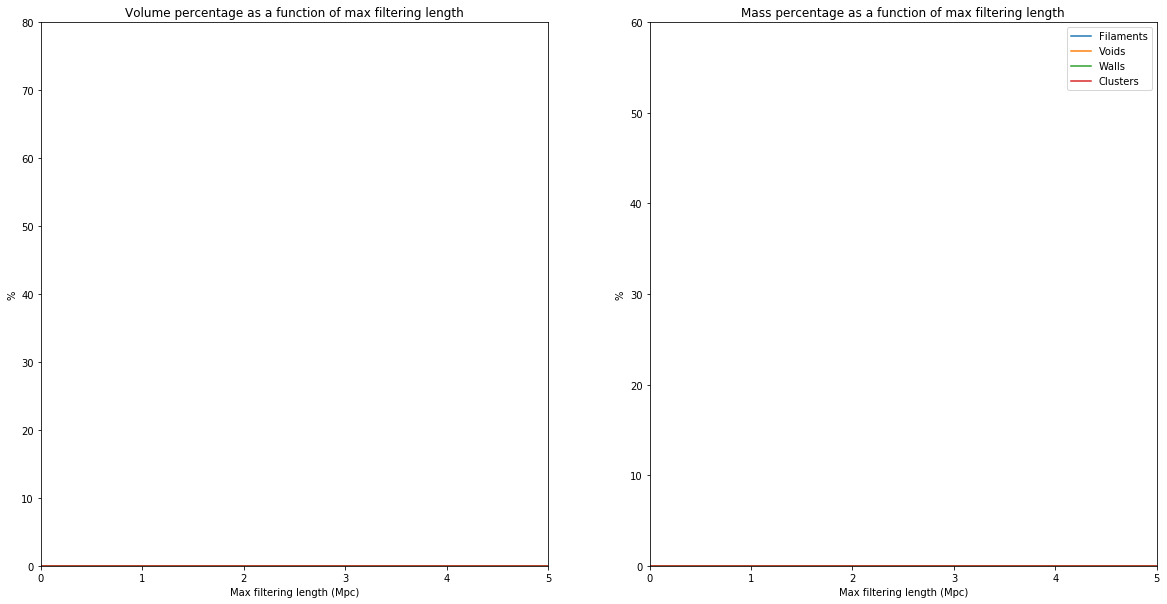

In [91]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(zarr,vparr[:,0],label="Filaments")
ax1.plot(zarr,vparr[:,1],label="Voids")
ax1.plot(zarr,vparr[:,2],label="Walls")
ax1.plot(zarr,vparr[:,3],label="Clusters")
ax1.set_xlim(0,5)
ax1.set_ylim(0,80)
ax1.set_xlabel("Max filtering length (Mpc)")
ax1.set_ylabel("%")
ax1.set_title("Volume percentage as a function of max filtering length")
ax2 = fig.add_subplot(122)
ax2.plot(zarr,mparr[:,0],label="Filaments")
ax2.plot(zarr,mparr[:,1],label="Voids") 
ax2.plot(zarr,mparr[:,2],label="Walls")
ax2.plot(zarr,mparr[:,3],label="Clusters")
ax2.set_xlim(0,5)
ax2.set_ylim(0,60)
ax2.legend()
ax2.set_xlabel("Max filtering length (Mpc)")
ax2.set_ylabel("%")
ax2.set_title("Mass percentage as a function of max filtering length")
plt.show()

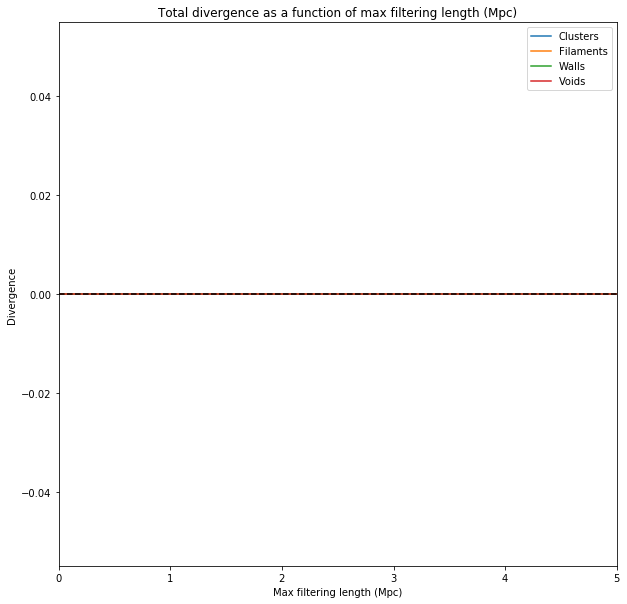

In [92]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.plot(zarr[4:],avdiv[4:,0],label="Clusters")
ax1.plot(zarr,avdiv[:,1],label="Filaments")
ax1.plot(zarr,avdiv[:,2],label="Walls")
ax1.plot(zarr,avdiv[:,3],label="Voids")
ax1.axhline(0,linestyle="dashed",color="black")
ax1.set_xlim(0,5)
#ax1.set_ylim(0,72)
ax1.set_xlabel("Max filtering length (Mpc)")
ax1.set_ylabel("Divergence")
plt.legend()
ax1.set_title("Total divergence as a function of max filtering length (Mpc)")
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.plot(zarr[4:],avdiv[4:,0],label="Clusters")
ax1.plot(zarr,avdiv[:,1],label="Filaments")
ax1.plot(zarr,avdiv[:,2],label="Walls")
ax1.plot(zarr,avdiv[:,3],label="Voids")
ax1.axhline(0,linestyle="dashed",color="black")
ax1.set_xlim(0,5)
ax1.set_ylim(-5000,5000)
ax1.set_xlabel("Max filtering length (Mpc)")
ax1.set_ylabel("Divergence")
plt.legend()
ax1.set_title("Total divergence as a function of max filtering length (Mpc)")
plt.show()